## License

Copyright 2020 Google LLC

Licensed under the the Apache License v2.0 with LLVM Exceptions (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://llvm.org/LICENSE.txt

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [115]:
import requests
import os
import logging
import argparse
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
cache_file = "cache.json"
token = f'Bearer {os.getenv("BUILDKITE_API_TOKEN")}'
builds = []

In [79]:
if os.path.exists(cache_file):
    with open(cache_file) as f:
        builds = json.load(f)
        print(f'loaded {len(builds)} entries') 

loaded 9926 entries


In [96]:
# load new jobs from Buildkite API
if True:
    existing = set()
    for j in builds:
        existing.add(j['id'])

    # uncomment to reset
    builds = []
    existing = set()
    page = 1
    stop = False
    while not stop:
        print('loading page', page)
        re = requests.get('https://api.buildkite.com/v2/organizations/llvm-project/builds',
                          params={'page': page},
                          headers={'Authorization': token})
        if re.status_code != 200:
            print('response status', re.status_code, re)
            break
        x = re.json()
        if x == []:
            print('empty response')
            break
        for j in x:
            if j['id'] in existing:
                print('found existing job', j['id'])
                stop = True
                break
            # TODO: skip running jobs            
            if (j['state'] == 'running') or (j['state'] == 'scheduled'):
                print(j['web_url'], 'is', j['state'], 'skipping')
                continue
            builds.append(j)
        page += 1
    print(len(builds), 'jobs in total')    
    with open(cache_file, 'w') as f:
        json.dump(builds, f)
    print(f'saved {len(builds)} entries')

loading page 1
https://buildkite.com/llvm-project/premerge-checks/builds/4056 is running skipping
https://buildkite.com/llvm-project/diff-checks/builds/4771 is running skipping
https://buildkite.com/llvm-project/llvm-master-build/builds/313 is running skipping
loading page 2
loading page 3
loading page 4
loading page 5
loading page 6
loading page 7
loading page 8
loading page 9
loading page 10
loading page 11
loading page 12
loading page 13
loading page 14
loading page 15
loading page 16
loading page 17
loading page 18
loading page 19
loading page 20
loading page 21
loading page 22
loading page 23
loading page 24
loading page 25
loading page 26
loading page 27
loading page 28
loading page 29
loading page 30
loading page 31
loading page 32
loading page 33
loading page 34
loading page 35
loading page 36
loading page 37
loading page 38
loading page 39
loading page 40
loading page 41
loading page 42
loading page 43
loading page 44
loading page 45
loading page 46
loading page 47
loading pag

In [92]:
builds[7007]

{'id': 'a2711b08-9b6a-42d5-b4b6-6c59c1552de5',
 'url': 'https://api.buildkite.com/v2/organizations/llvm-project/pipelines/premerge-checks/builds/939',
 'web_url': 'https://buildkite.com/llvm-project/premerge-checks/builds/939',
 'number': 939,
 'state': 'passed',
 'blocked': False,
 'message': ':rocket: build and test',
 'commit': 'ea6b09b8619acacb33fcd203f221478008ecaf3a',
 'branch': 'phab-diff-271774',
 'tag': None,
 'env': {'ph_build_id': '73722',
  'ph_target_phid': 'PHID-HMBT-4acp7qthh3xglytj6u5m',
  'scripts_branch': 'master',
  'ph_buildable_diff': '271774',
  'ph_initiator_phid': 'PHID-HRUL-pvs6c7dbp4vlzqcixysi',
  'ph_scripts_branch': 'master',
  'ph_buildable_revision': '82048'},
 'source': 'trigger_job',
 'creator': {'id': '2dd32c51-ad7e-4624-a8a0-4131b3677b92',
  'name': 'premerge bot',
  'email': 'llvm.premerge.tests@gmail.com',
  'avatar_url': 'https://www.gravatar.com/avatar/43ac7ccfca24b7e2132c9afa165a9f30',
  'created_at': '2020-05-14T10:32:08.557Z'},
 'created_at': '2

In [107]:
d = {
    'id': [],
    'number': [],
    'pipeline': [],
}

jobs = {
    'pipeline': [],
    'name': [],
    'step_key': [],
    'state': [],
    'exit_status': [],
    'agent_id': [],
    'agent_name': [],
    'runnable_at': [],
    'started_at': [],
    'wait_duration': [],
    'finished_at': [],
    'run_duration': [],
}

sec = np.timedelta64(1, 's')
for b in builds:
    d['id'].append(b['id'])
    d['number'].append(b['number'])
    d['pipeline'].append(b['pipeline']['slug'])
    for x in b['jobs']:
        if x['state'] in ['waiting_failed', 'canceled', 'skipped', 'broken']:
            continue
        try:
            jobs['pipeline'].append(b['pipeline']['slug'])
            jobs['name'].append(x['name'])
            jobs['step_key'].append(x['step_key'] if 'step_key' in x else '')
            jobs['state'].append(x['state'] )
            jobs['exit_status'].append(x['exit_status'] if 'exit_status' in x else -1)
            jobs['agent_id'].append(x['agent']['id'] if 'agent' in x else '')
            jobs['agent_name'].append(x['agent']['name'] if 'agent' in x else '')
            runnable = np.datetime64(x['runnable_at'].replace('Z', ''))
            started = np.datetime64(x['started_at'].replace('Z', ''))
            finished = np.datetime64(x['finished_at'].replace('Z', ''))
            jobs['runnable_at'].append(runnable)
            jobs['started_at'].append(started)
            jobs['wait_duration'].append((started - runnable) / sec)
            jobs['finished_at'].append(finished)
            jobs['run_duration'].append((finished - started) / sec)
        except Exception as e:
            print(x)
            raise e            
jobs = pd.DataFrame(jobs)

In [122]:
jobs.pipeline.unique()

array(['premerge-checks', 'diff-checks', 'llvm-master-build',
       'cleanup-branches', 'llvm-releases'], dtype=object)

In [108]:
jobs

,pipeline,name,step_key,state,exit_status,agent_id,agent_name,runnable_at,started_at,wait_duration,finished_at,run_duration
0,premerge-checks,:seedling: setup,None,passed,0,5725b783-8dbd-4f2a-868b-43672fda1517,premerge-debian-79cddc6ddb-xcdj8-2,2020-07-16 12:50:04,2020-07-16 12:50:08.673,4.673,2020-07-16 12:50:25.259,16.586
1,premerge-checks,:linux: build and test linux,linux,failed,-1,5725b783-8dbd-4f2a-868b-43672fda1517,premerge-debian-79cddc6ddb-xcdj8-2,2020-07-16 12:50:25,2020-07-16 12:50:28.668,3.668,2020-07-16 12:59:19.455,530.787
2,premerge-checks,:windows: build and test windows,windows,passed,0,f4f2789e-50aa-4dfb-88e9-267df8227508,w64,2020-07-16 12:50:25,2020-07-16 12:50:29.645,4.645,2020-07-16 13:04:03.301,813.656
3,premerge-checks,:spiral_note_pad: report,None,passed,0,152a7c38-8e6c-438b-8123-fafb92ff2afd,premerge-debian-79cddc6ddb-snd9j-2,2020-07-16 13:04:03,2020-07-16 13:04:12.266,9.266,2020-07-16 13:04:23.550,11.284
4,diff-checks,:seedling: setup,None,passed,0,5725b783-8dbd-4f2a-868b-43672fda1517,premerge-debian-79cddc6ddb-xcdj8-2,2020-07-16 12:49:18,2020-07-16 12:49:18.663,0.663,2020-07-16 12:49:20.104,1.441
...,...,...,...,...,...,...,...,...,...,...,...,...
31143,llvm-releases,ninja all,None,failed,1,1346c13a-6aca-49cb-b76f-9c248c2e53eb,2b3f2bb62dfe-1,2019-11-07 17:04:11,2019-11-07 17:04:18.898,7.898,2019-11-07 17:04:23.296,4.398
31144,llvm-releases,,None,failed,9009,1346c13a-6aca-49cb-b76f-9c248c2e53eb,2b3f2bb62dfe-1,2019-11-07 16:59:15,2019-11-07 16:59:16.770,1.770,2019-11-07 17:02:41.360,204.590
31145,llvm-releases,,None,failed,9009,1346c13a-6aca-49cb-b76f-9c248c2e53eb,2b3f2bb62dfe-1,2019-11-07 16:59:15,2019-11-07 17:02:41.760,206.760,2019-11-07 17:02:46.147,4.387
31146,llvm-releases,,None,failed,1,1346c13a-6aca-49cb-b76f-9c248c2e53eb,2b3f2bb62dfe-1,2019-11-07 16:00:46,2019-11-07 16:57:53.596,3427.596,2019-11-07 16:58:07.712,14.116


In [142]:
ds = jobs[jobs['pipeline'] == 'llvm-master-build'][jobs['step_key'] == 'windows'][jobs['state']=='passed'][~jobs['agent_name'].str.startswith('buildkite-')]

/usr/local/google/home/goncharov/etc/merge-checks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [146]:
ds

,pipeline,name,step_key,state,exit_status,agent_id,agent_name,runnable_at,started_at,wait_duration,finished_at,run_duration
181,llvm-master-build,:windows: build and test windows,windows,passed,0,5c0f2d87-607b-4ae7-a44c-7a382a0e7705,w1,2020-07-16 08:01:15,2020-07-16 08:11:48.930,633.930,2020-07-16 08:50:32.852,2323.922
267,llvm-master-build,:windows: build and test windows,windows,passed,0,5c0f2d87-607b-4ae7-a44c-7a382a0e7705,w1,2020-07-16 04:01:16,2020-07-16 06:50:58.490,10182.490,2020-07-16 08:11:43.778,4845.288
440,llvm-master-build,:windows: build and test windows,windows,passed,0,e503ea2c-8fff-40d9-bc64-299869ccccff,w-no-ssd,2020-07-16 00:01:46,2020-07-16 00:01:51.426,5.426,2020-07-16 01:22:54.629,4863.203
625,llvm-master-build,:windows: build and test windows,windows,passed,0,17eda84a-51c1-44f1-950f-a1304ac55456,w1,2020-07-15 20:02:07,2020-07-15 20:02:09.353,2.353,2020-07-15 21:00:32.799,3503.446
863,llvm-master-build,:windows: build and test windows,windows,passed,0,a2f3c85b-378e-4223-858a-ce7a494ff640,w5,2020-07-15 16:01:03,2020-07-15 16:01:12.283,9.283,2020-07-15 16:55:52.946,3280.663
...,...,...,...,...,...,...,...,...,...,...,...,...
25093,llvm-master-build,:windows: build and test windows,windows,passed,0,283e8832-4e87-49c6-93ce-5d7d7e521344,w5,2020-06-17 12:01:24,2020-06-17 12:01:27.363,3.363,2020-06-17 13:29:18.491,5271.128
25258,llvm-master-build,:windows: build and test windows,windows,passed,0,142ddc24-79ae-4f89-b5b3-30ce39c62fb0,w6,2020-06-17 08:02:07,2020-06-17 08:02:11.264,4.264,2020-06-17 09:24:04.261,4912.997
28534,llvm-master-build,:windows: build and test windows,windows,passed,0,62e608ec-76e4-430d-8f7d-be2d9b2ca729,windows-dev,2020-06-06 04:01:47,2020-06-06 04:01:52.303,5.303,2020-06-06 05:14:32.464,4360.161
28659,llvm-master-build,:windows: build and test windows,windows,passed,0,62e608ec-76e4-430d-8f7d-be2d9b2ca729,windows-dev,2020-06-05 20:01:37,2020-06-05 20:01:40.598,3.598,2020-06-05 20:54:39.448,3178.850


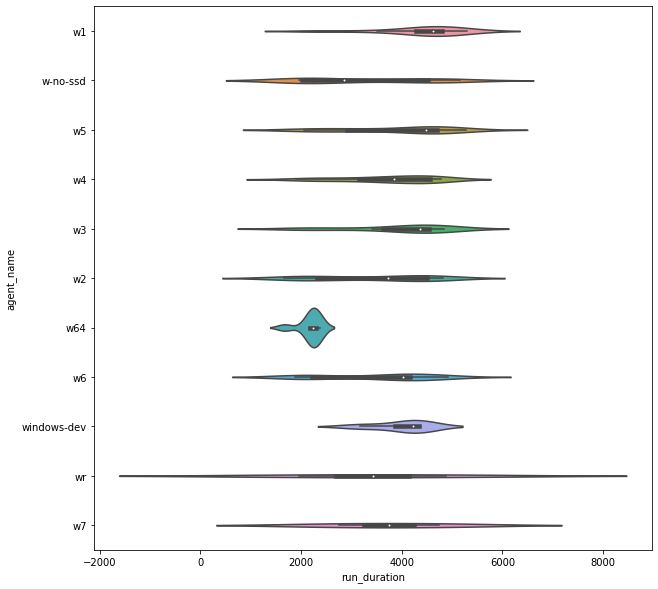

In [144]:
  fig, ax = plt.subplots(figsize=(10,10)) # size of the plot (width, height)

  sns.violinplot(
        ax=ax,
        x='run_duration',
        y='agent_name',
        split=True,
        data=ds)

In [145]:
pd.pivot_table(ds, values=['run_duration'], index=['agent_name'],
                    aggfunc=[np.median, np.mean, np.std])

,median,mean,std
,run_duration,run_duration,run_duration
agent_name,,,
w-no-ssd,2850.9130,3247.563941,1282.447187
w1,4622.4640,4402.738182,845.100475
w2,3721.4650,3384.658500,1164.059499
w3,4361.7415,3924.218400,1015.238411
w4,3854.8910,3736.914565,923.383163
w5,4481.5830,3896.175667,1088.397638
w6,4018.8300,3459.808882,1101.520573
w64,2230.6670,2181.231625,217.800498
